### Intro

Here is Conor and Will's computational project. The system we are investigating is a harmonograph ($\href{https://youtu.be/HJYvc-ISrf8?si=28UPteGFD0hYIdjX}{\text{Check This Out}}$). The system distills into two coupled pendulums and a third uncoupled one.

Here is our non dimensional Lagrangian:

\begin{equation}
    L = \frac{1}{2}\rho_3\dot{\theta}^{2}_{3} + \frac{1}{2}(1+\rho_2\)\gamma^{2}dot{\theta}^{2}_{3}
\end{equation}

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#-------Parameters---------#
rho2, gamma2 = 1, 1

#------Variables----------#


First, we need want to solve the double pendulum, because the single pendulum added onto it will be easy.
We want to solve the following system:

\begin{equation}
\begin{split}
           (1 + \rho_2)\ddot{\theta}_1 + \rho_2\gamma_2\cos(\theta_2 - \theta_1)\ddot{\theta}_2 - \rho_2\gamma_2\sin(\theta_2 - \theta_1)\dot{\theta}_2 = - (1+\rho_2)\sin(\theta_1)   // 
           \gamma_2\ddot{\theta}_2 + \ddot{\theta}
\end{split}
\end{equation}

In [ ]:
def first_function(theta1, theta2, theta2dot, theta1ddot, theta2ddot, p2, gamma2):
    return
    

In [50]:
def vectorfield(w, t, p):
    """
    Defines the differential equations for the double pendulum.

    ***could modify to include the single one too!!!


    ***basically all comments are wrong!!!!!**********

    Arguments:
        w :  vector of the state variables:
                  w0 = [θ1, x1, θ2, x2, θ3, x3]
        t :  time
        p :  vector of the parameters:
                  p = [p2, g2, g3]
    """
    θ1, x1, θ2, x2, θ3, x3 = w
    p2, g2, g3 = p

    # Create f = (θ1',x1',θ2',x2',θ3',x3'):
    f = [x1,
         (p2*g2*x2**2*np.sin(θ2-θ1)+x1**2*np.sin(2*(θ2-θ1))/2+p2*np.sin(θ2)*np.cos(θ2-θ1)-np.sin(θ1)) / (1-p2*np.cos(θ2-θ1)**2),
         x2,
         (x1**2*np.sin(θ2-θ1)+p2*g2*x2**2*np.sin(2*(θ2-θ1))/2-np.sin(θ1)*np.cos(θ2-θ1)+np.sin(θ2)) / (p2*g2*np.cos(θ2-θ1)**2-g2),
         x3,
         -np.sin(θ3)/g3]
    return f

In [51]:
# Use ODEINT to solve the differential equations defined by the vector field

# Parameter values
# p2 = "p2"/(1+"p2"); "p2" = m2/m1; g2=l2/l1; g3=l3/l1
p2 = 0.5
g2 = 1
g3 = 1

# Initial conditions
# θ_ are the initial angles; x_ are the initial nondiminsionalized angular velocities
θ1 = 0.5
x1 = 0.0
θ2 = 2.25
x2 = 0.0
θ3 = 1
x3 = 0

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 10.0
numpoints = 250

# Create the time samples for the output of the ODE solver.
# I use a large number of points, only because I want to make
# a plot of the solution that looks nice.
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

# Pack up the parameters and initial conditions:
p = [p2, g2, g3]
w0 = [θ1, x1, θ2, x2, θ3, x3]

# Call the ODE solver.
wsol = odeint(vectorfield, w0, t, args=(p,),
              atol=abserr, rtol=relerr)


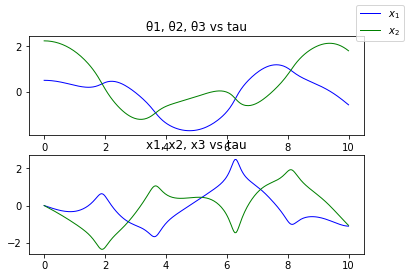

In [52]:
θ1 = wsol[:,0]
x1 = wsol[:,1]
θ2 = wsol[:,2]
x2 = wsol[:,3]
θ3 = wsol[:,4]
x3 = wsol[:,5]

lw = 1

[fig, ax] = plt.subplots(2)

ax[0].plot(t, θ1, 'b', linewidth=lw)
ax[0].plot(t, θ2, 'g', linewidth=lw)
# ax[0].plot(t, θ3, 'r', linewidth=lw)

ax[0].set_title('θ1, θ2, θ3 vs tau');

ax[1].plot(t, x1, 'b', linewidth=lw)
ax[1].plot(t, x2, 'g', linewidth=lw)
# ax[1].plot(t, x3, 'r', linewidth=lw)

ax[1].set_title('x1, x2, x3 vs tau');


fig.legend((r'$x_1$', r'$x_2$'));